# Run GeoClaw with various parameter choices

Normally the GeoClaw fortran code is run by first adjusting the parameters in `setrun.py` and then executing `make .output` or `make .plots` at the command line.

Here we do some runs from within the notebook in order to include some discussion of how different settings affect the results obtained.  We do this using some notebook tools from `clawpack.clawutil.nbtools`.

Before exectuting this notebook (or running GeoClaw from the command line), it is necessary to run the notebook [make_input_files.ipynb](make_input_files.ipynb) to create some input files required by GeoClaw.

Or you can run the python script version via:

    python make_input_files.py

In [1]:
%matplotlib inline

In [2]:
# set dpi so that imshow works better for displaying png files:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [3]:
from pylab import *
from IPython.display import Image
import os
from importlib import reload
from clawpack.clawutil import nbtools
from clawpack.pyclaw import solution

In [4]:
from clawpack.geoclaw import topotools, marching_front, dtopotools
from clawpack.visclaw import plottools, gridtools

#### Define a convenience function to display 3 frames from a simulation, side by side:

In [5]:
def plot_3frames(plotdir, figno=0, framenos=[0,1,2]):
    print('Plotting figure %s, frames %s from %s' % (figno,framenos,plotdir))
    frames = []
    figure(figsize=(10,10))
    for k in range(3):
        subplot(1,3,k+1)
        frameno = framenos[k]
        png_file = os.path.join(plotdir, \
                                'frame000%sfig%s.png' % (frameno,figno))
        frame = imread(png_file)
        imshow(frame)
        axis('off')
    tight_layout()

### Compile the fortran code:

In [6]:
nbtools.make_exe(new=True, verbose=False)

You can check the output from the compilation at [compile_output.txt](compile_output.txt).

### Set up the first run

We use the parameters set in `setrun_notebook.py` (just in case you have changed things in `setrun.py` in the course of your own experiments):

In [7]:
if 1:
    # for debugging
    from importlib import reload
    import setrun_notebook
    reload(setrun_notebook)

In [8]:
from setrun_notebook import setrun
rundata = setrun() 
rundata.write()

The original `setrun_notebook.py` should be set up to run for 25 minutes of simulated time, with output every 5 minutes.  It is also set up to **not** use the `variable_eta_init` option or a `force_dry_init` array.  Check this:

In [9]:
print('rundata.clawdata.tfinal = ',rundata.clawdata.tfinal)
print('rundata.clawdata.num_output_times = ',rundata.clawdata.num_output_times)
print('rundata.qinit_data.variable_eta_init = ',rundata.qinit_data.variable_eta_init)
print('rundata.qinit_data.force_dry_list = ',rundata.qinit_data.force_dry_list)

rundata.clawdata.tfinal =  1500.0
rundata.clawdata.num_output_times =  5
rundata.qinit_data.variable_eta_init =  False
rundata.qinit_data.force_dry_list =  []


## Run GeoClaw and make plots

Using the `nbtools` module, we can run the code and make plots, putting the output and plots in directories with a distinct label in case you later want to compare them:

In [10]:
# Run the code with the original parameter settings
outdir,plotdir = nbtools.make_output_and_plots(label='1',verbose=True)

Executing shell command:   make output OUTDIR=_output_1
Done...  Check this file to see output:


/Users/rjl/clawpack_src/clawpack_master/geoclaw/examples/tsunami/eta_init_force_dry/run_output_1.txt

Executing shell command:   make plots OUTDIR=_output_1 PLOTDIR=_plots_1
Done...  Check this file to see output:


/Users/rjl/clawpack_src/clawpack_master/geoclaw/examples/tsunami/eta_init_force_dry/plot_output_1.txt

View plots created at this link:


/Users/rjl/clawpack_src/clawpack_master/geoclaw/examples/tsunami/eta_init_force_dry/_plots_1/_PlotIndex.html

### Plot the first 3 frames...

The full domain shows the tsunami initiating, with the leading depression (dark blue) near the coast:

Plotting figure 0, frames [0, 1, 2] from _plots_1


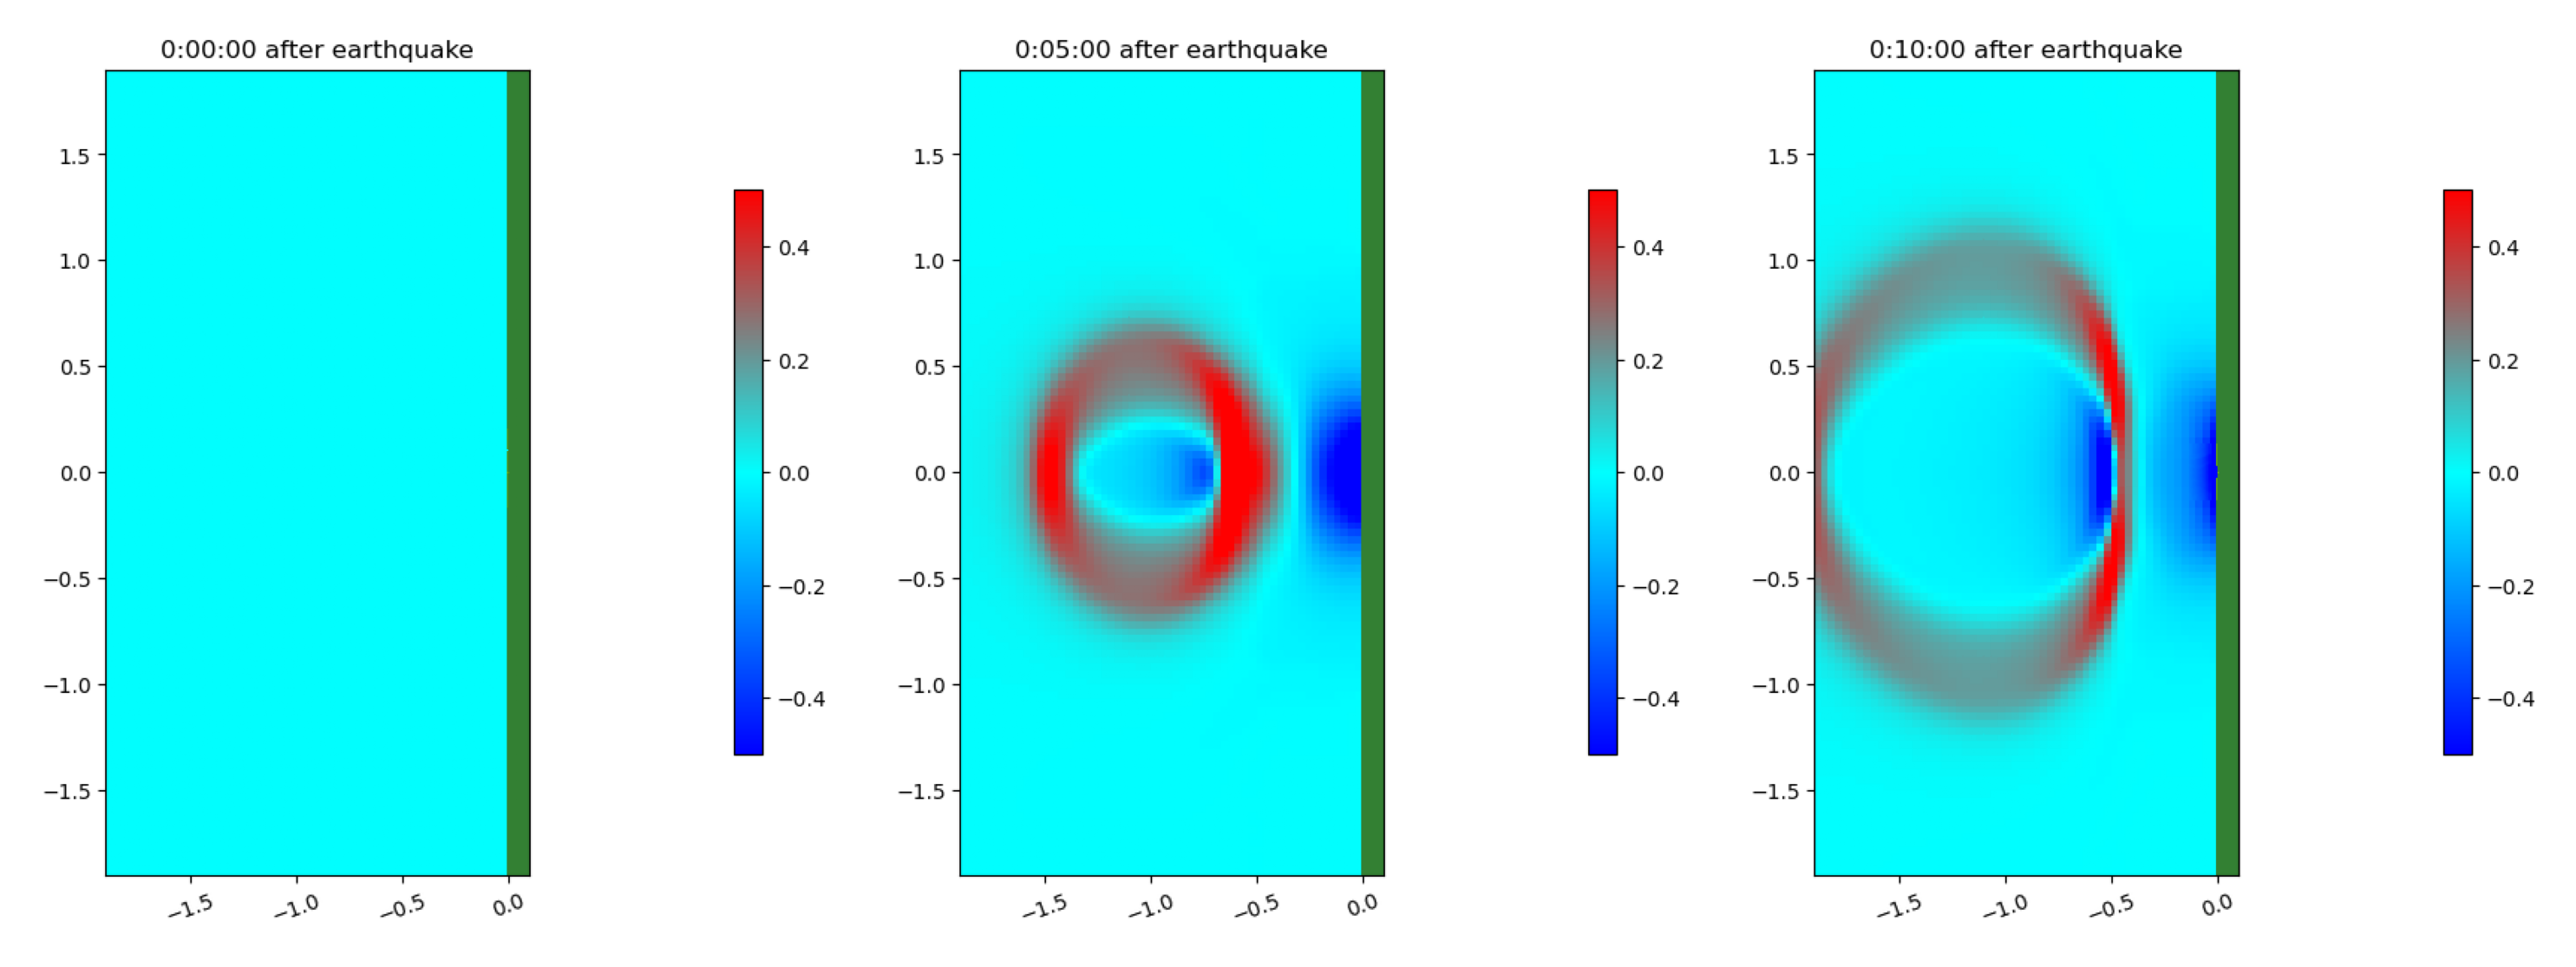

In [11]:
plotdir = '_plots_1'
plot_3frames(plotdir, figno=0)

### The coastal region

Figure 11 shows a zoom on the coastal region (as set up in `setplot.py`):

Plotting figure 11, frames [0, 1, 2] from _plots_1


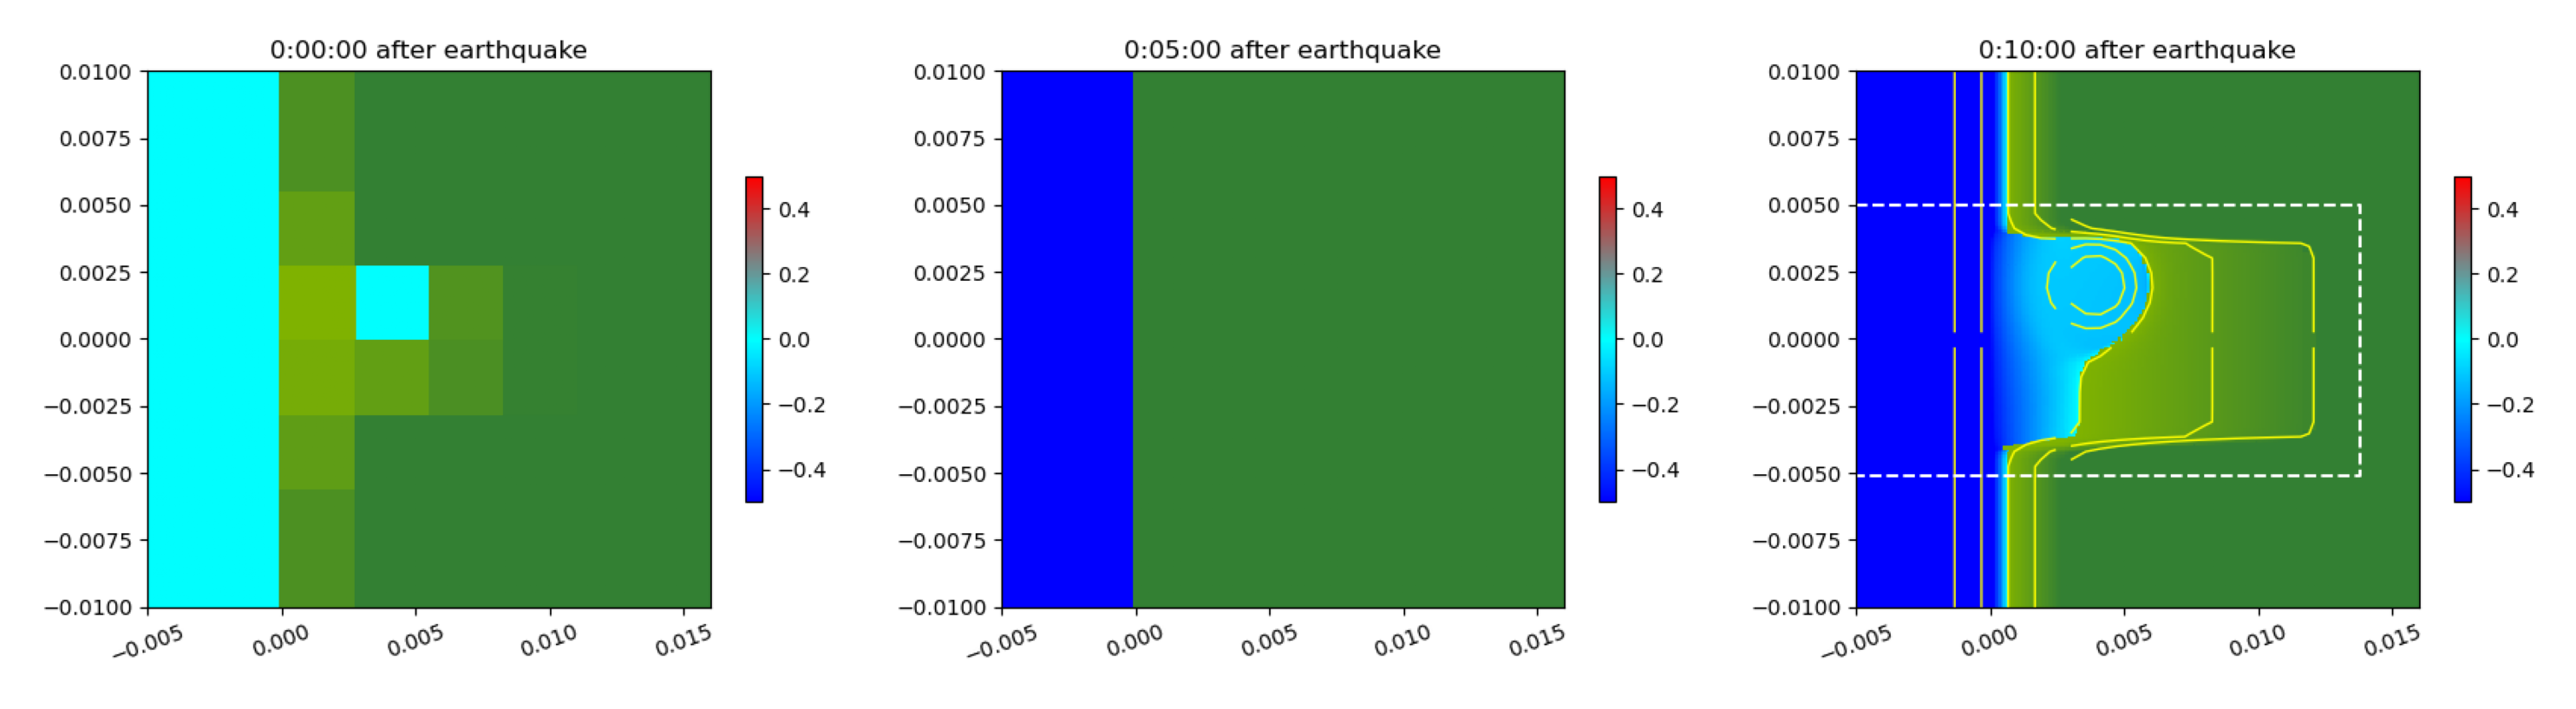

In [12]:
plotdir = '_plots_1'
plot_3frames(plotdir, figno=11)

The three plots above show a zoomed view along the coast. Note the following:

 - The water is colored by elevation of the surface (relative to `sea_level = 0` in this simulation), with darker blue showing elevations below 0 and reds showing elevations above 0. In `setplot.py` we use `plotitem.plot_var = geoplot.surface` to plot this. Often we use `plotitem.plot_var = geoplot.surface_or_depth` which assigns colors based on surface offshore and based on depth of water onshore.  This is more useful in some cases but misleading here since it determines "onshore" based on the topography values.
 
 - At time 0 only levels 1 and 2 are present, by 5 minutes level 3 has been added, and by time 10 minutes, the 4th level has appeared.  Level 4 is required only after `t = 5*60.` (5 minutes) and only in the white dashed rectangle.  
 
 - Yellow curves are contours of topo (as computed on level 3).  Because of the co-seismic subsidence, GeoClaw fills in with water to `z = 0` on this subsided topography and the region flooded agrees with what we expect from the plot below, which was produced in [make_input_files.ipynb](make_input_files.ipynb).  This is **not** what we want, and we address this in the tests below.

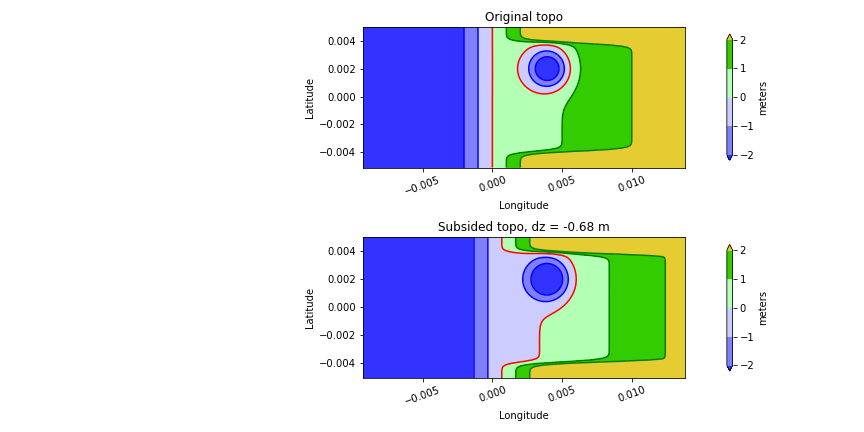

In [13]:
Image('topo_with_dz.png', width=600)

## Use `variable_eta_init`

Because we do not refine to Level 3 or 4 until after the earthquake has occurred, we do not want GeoClaw to fill in newly-created fine grid cells with water up `z = sea_level`, but only up to `z = sea_level + dz`, where `dz` is the change in elevation due to co-seismic deformation (negative for subsidence).

This can be requested by setting `rundata.qinit_data.variable_eta_init = True` in `setrun.py`, or in the notebook we can change this one value and re-create the `.data` files that will be read by GeoClaw:

In [14]:
rundata.qinit_data.variable_eta_init = True
rundata.write()

Re-run the code and save to a new set of directories:

In [15]:
label = '2'
outdir,plotdir = nbtools.make_output_and_plots(label=label,verbose=False)

This makes negligible change in the ocean-scale results, so we only show the new zoomed coastal plots:

Plotting figure 11, frames [0, 1, 2] from _plots_2


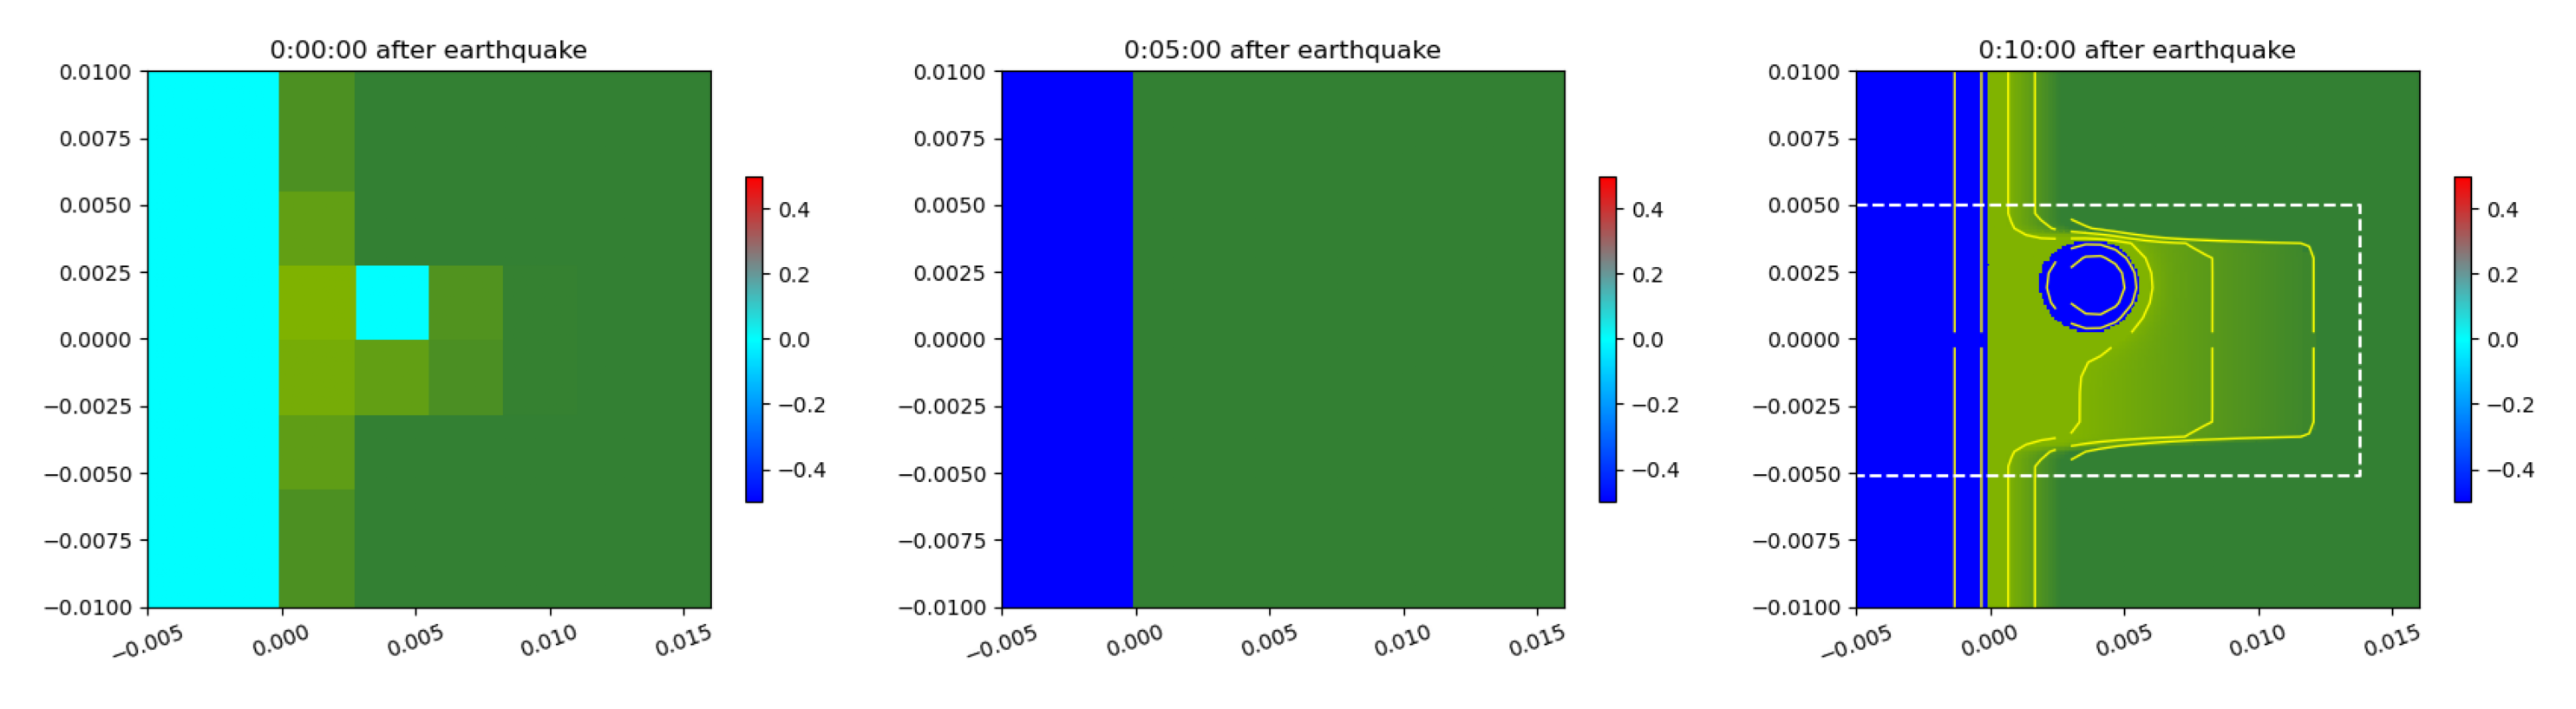

In [16]:
plotdir = '_plots_%s' % label
plot_3frames(plotdir, figno=11)

Now we see that the region that initially had `z > 0` remains dry initially in spite of the subsidence of the topography.

## Use the `force_dry_init` array

In [make_input_files.ipynb](make_input_files.ipynb) we created a file `input_files/force_dry_init.data` that specifies points that should be forced to be dry when new level 4 grids are initialized, even if the GeoClaw topo value is less than 0.  

We can use this by creating a Python object `ForceDry` specifying the filename and also the time period over which this should be used, and then appending this to `rundata.qinit_data.force_dry_list` as we do in the next cell.

Notes:

 - Currently at most one such object can be in the list, but in the future we will add support for specifying several `force_dry_init` arrays covering different regions and/or at different grid resolutions.
 
 - The array is used only when initializing grid patches that have exactly the same resolution as the `force_dry_init` array (and then it is assumed that grid points of this array coincide with cell centers on the patch).  Generally this is used to specify regions that should be forced dry on the finest level.  Coarser grid cells may not be dry in the same regions, but normally the finest grid level is introduced *before* the tsunami arrives so this hopefully does not matter.  (It is problematic trying to initialize coarser grids by e.g. interpolating into the finer `force_dry_init` array since on the coarser grid such a cell might be connected to the ocean by other coarse cells below sea level, and so forcing it to be dry might introduce a discontinuity in water level that leads to huge spurious waves on the coarser grids that pollute the entire computation.)
 
 - The ending time `force_dry.tend` is required because at times after the tsunami has come into a region we no longer want to force land to be dry.  The value of `force_dry.tend` should be chosen to be *after* the finest grids have been introduced in the region of interest but *before* the tsunami is expected to arrive.  In setting this, remember that if the finest grid level is required by some flagregion starting at some time `t1`, then that finest level will not actually exist in the computation until the next regridding time at higher levels when this is first seen, so the finer grids do not appear until somewhat later.  In the example used here, the level 4 grid is required in a flagregion that is active starting at 5 minutes, but the results shown above at 5 minutes still only show 3 levels.  For this reason we set `force_dry.tend = 7*60.` below, so `force_dry_init` array is used up to 7 minutes.  

In [17]:
from clawpack.geoclaw.data import ForceDry
force_dry = ForceDry()   # new data object
force_dry.tend = 7*60.  # force dry up to 7 minutes 
force_dry.fname = 'input_files/force_dry_init.tt3'
rundata.qinit_data.force_dry_list.append(force_dry)
rundata.write()

In [18]:
label='3'
outdir,plotdir = nbtools.make_output_and_plots(label=label,verbose=False)

Plotting figure 11, frames [0, 1, 2] from _plots_3


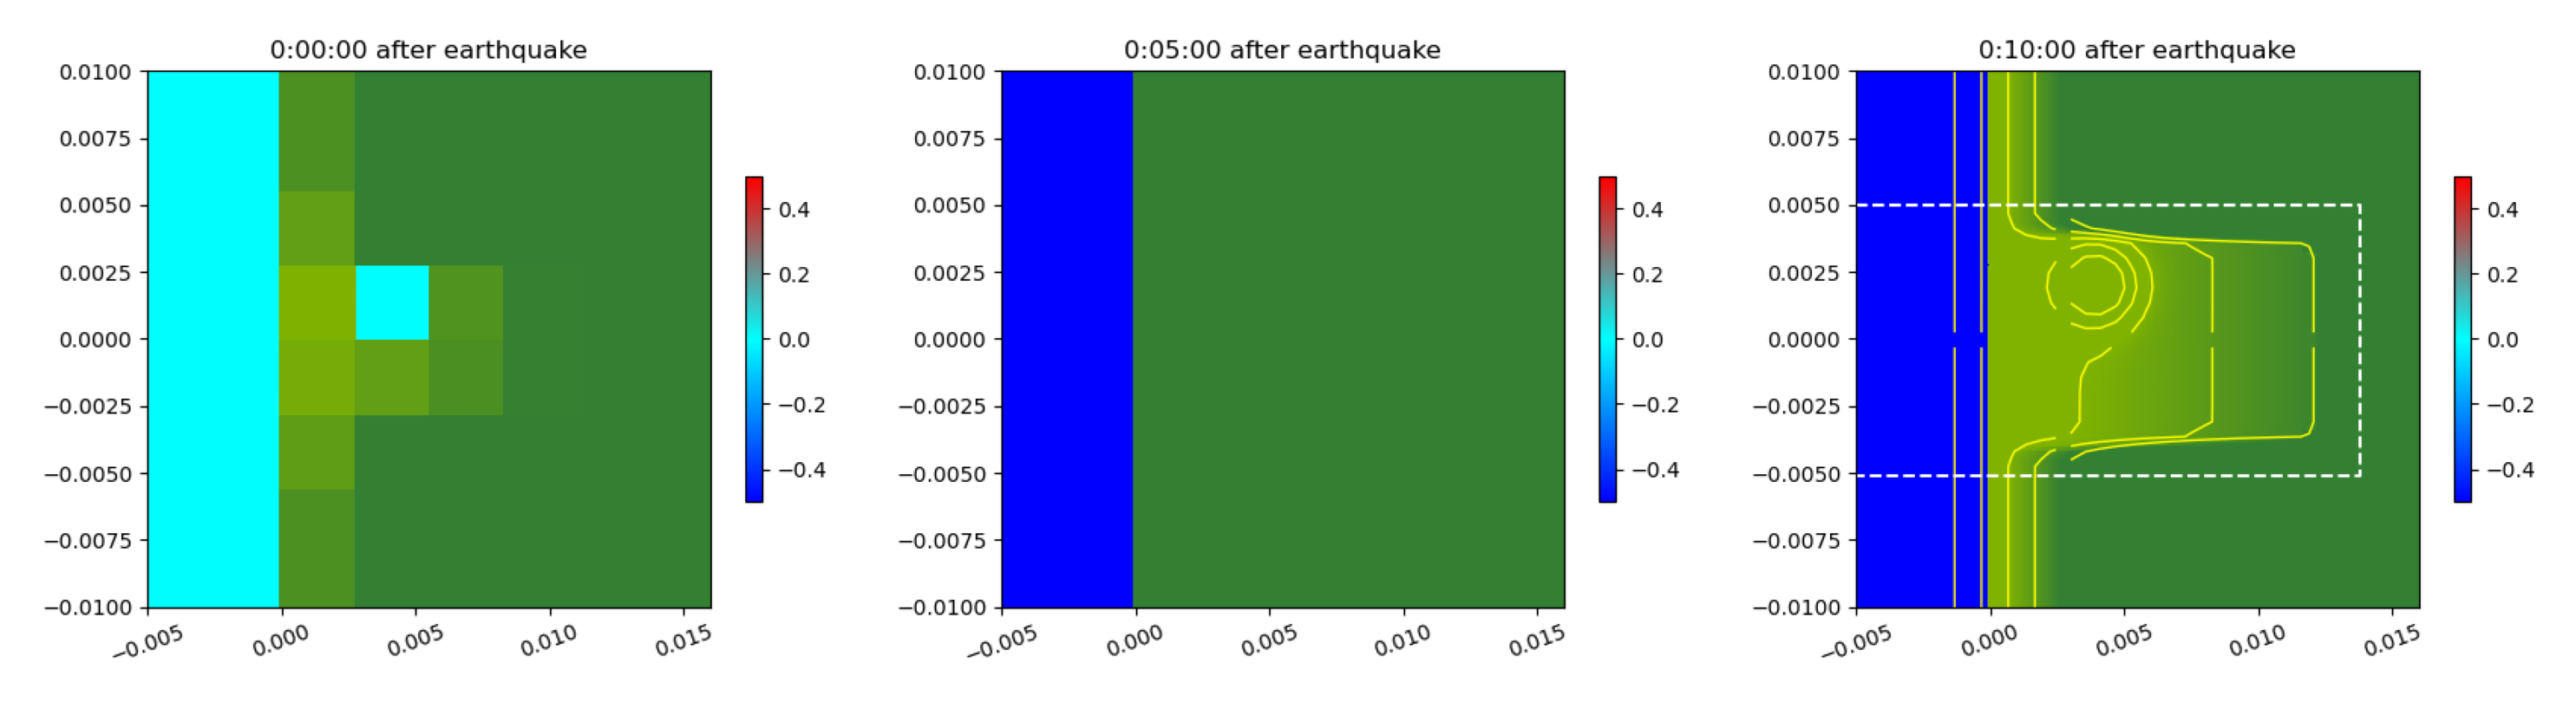

In [19]:
plotdir = '_plots_%s' % label
plot_3frames(plotdir, figno=11)

Note that, as discussed in the notes above, the onshore depression is filled with water on levels 2 and 3, but once level 4 is introduced the dry land at 10 minutes is correct in the plots above, and this has been properly initialized before the tsunami arrives.

## Results at later times

Now we compare the results at later times, after the positive tsunami has arrived on shore, to show how the different ways of initializing the computation affect the computed results.

The run just performed with `variable_eta_init` and `force_dry_init` gives these results at 15, 20, and 25 minutes post-quake:

Plotting figure 11, frames [3, 4, 5] from _plots_3


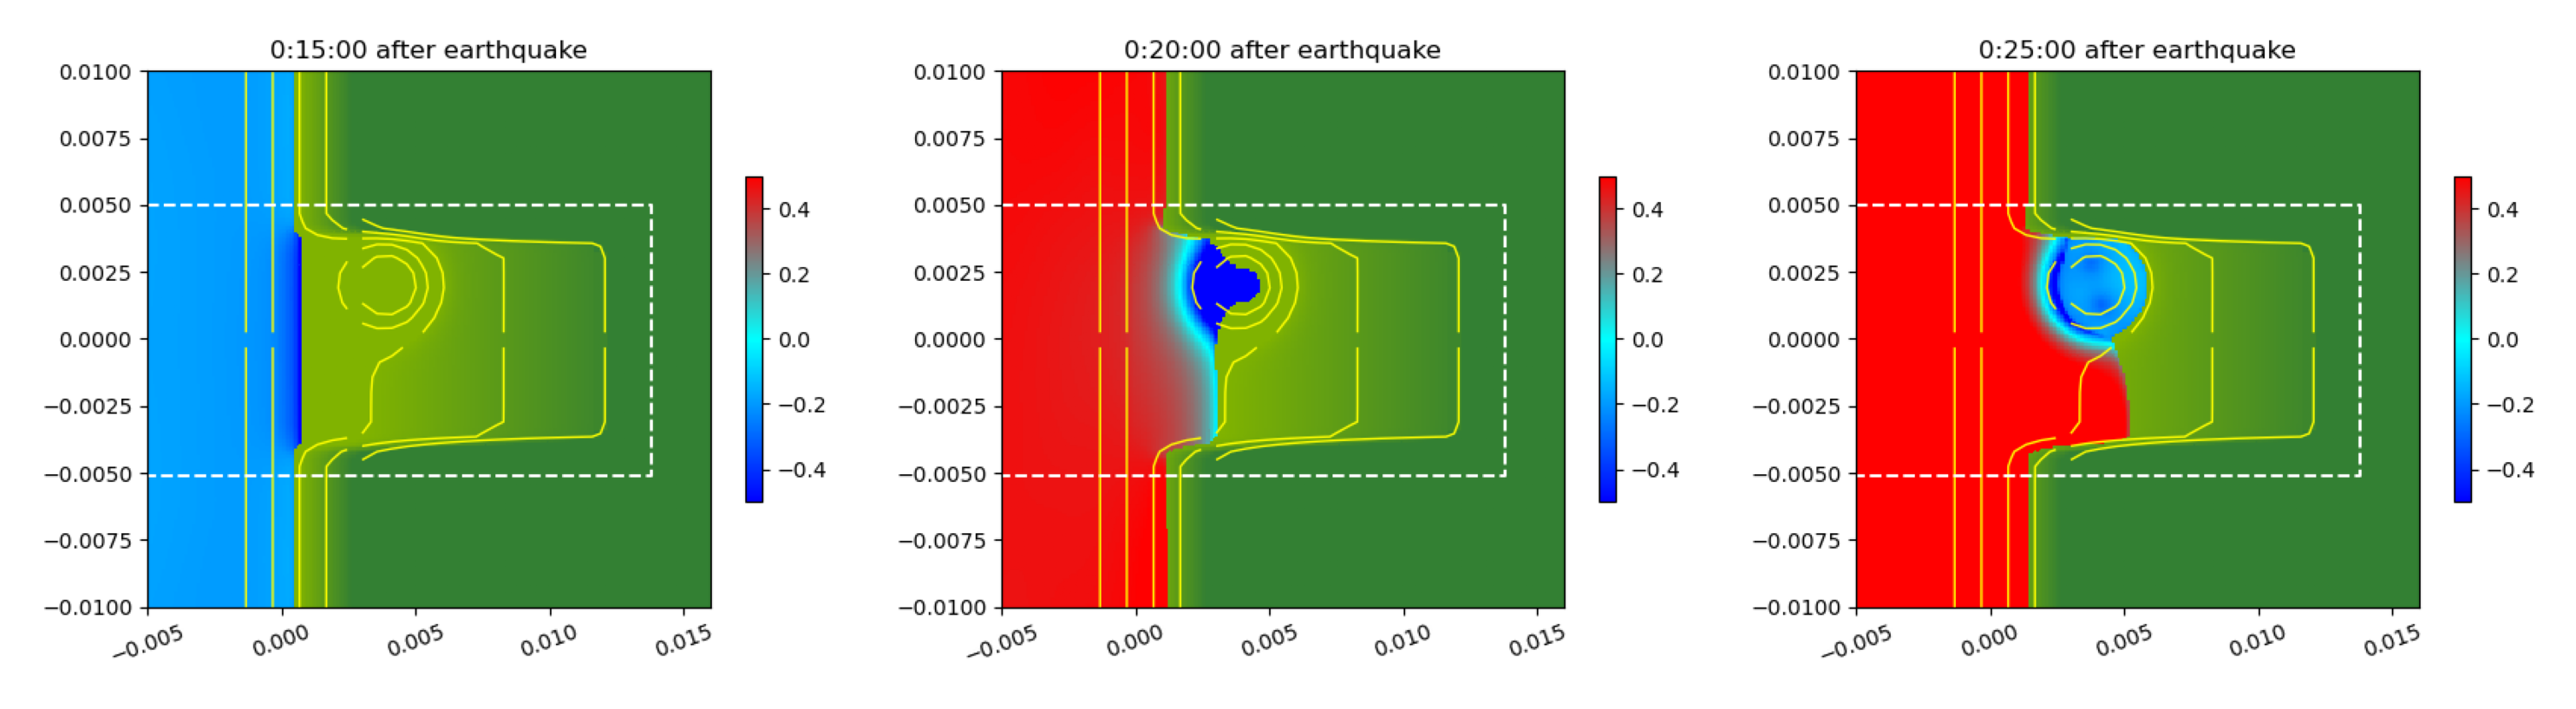

In [20]:
plotdir = '_plots_3'
plot_3frames(plotdir, figno=11, framenos=[3,4,5])

Note in the plots above that we can see the depression start to fill in with water as the tsunami flows around it.

By contrast, the original run we did, without `variable_eta_init` and `force_dry_init` gives these results at 15, 20, and 25 minutes post-quake:

Plotting figure 11, frames [3, 4, 5] from _plots_1


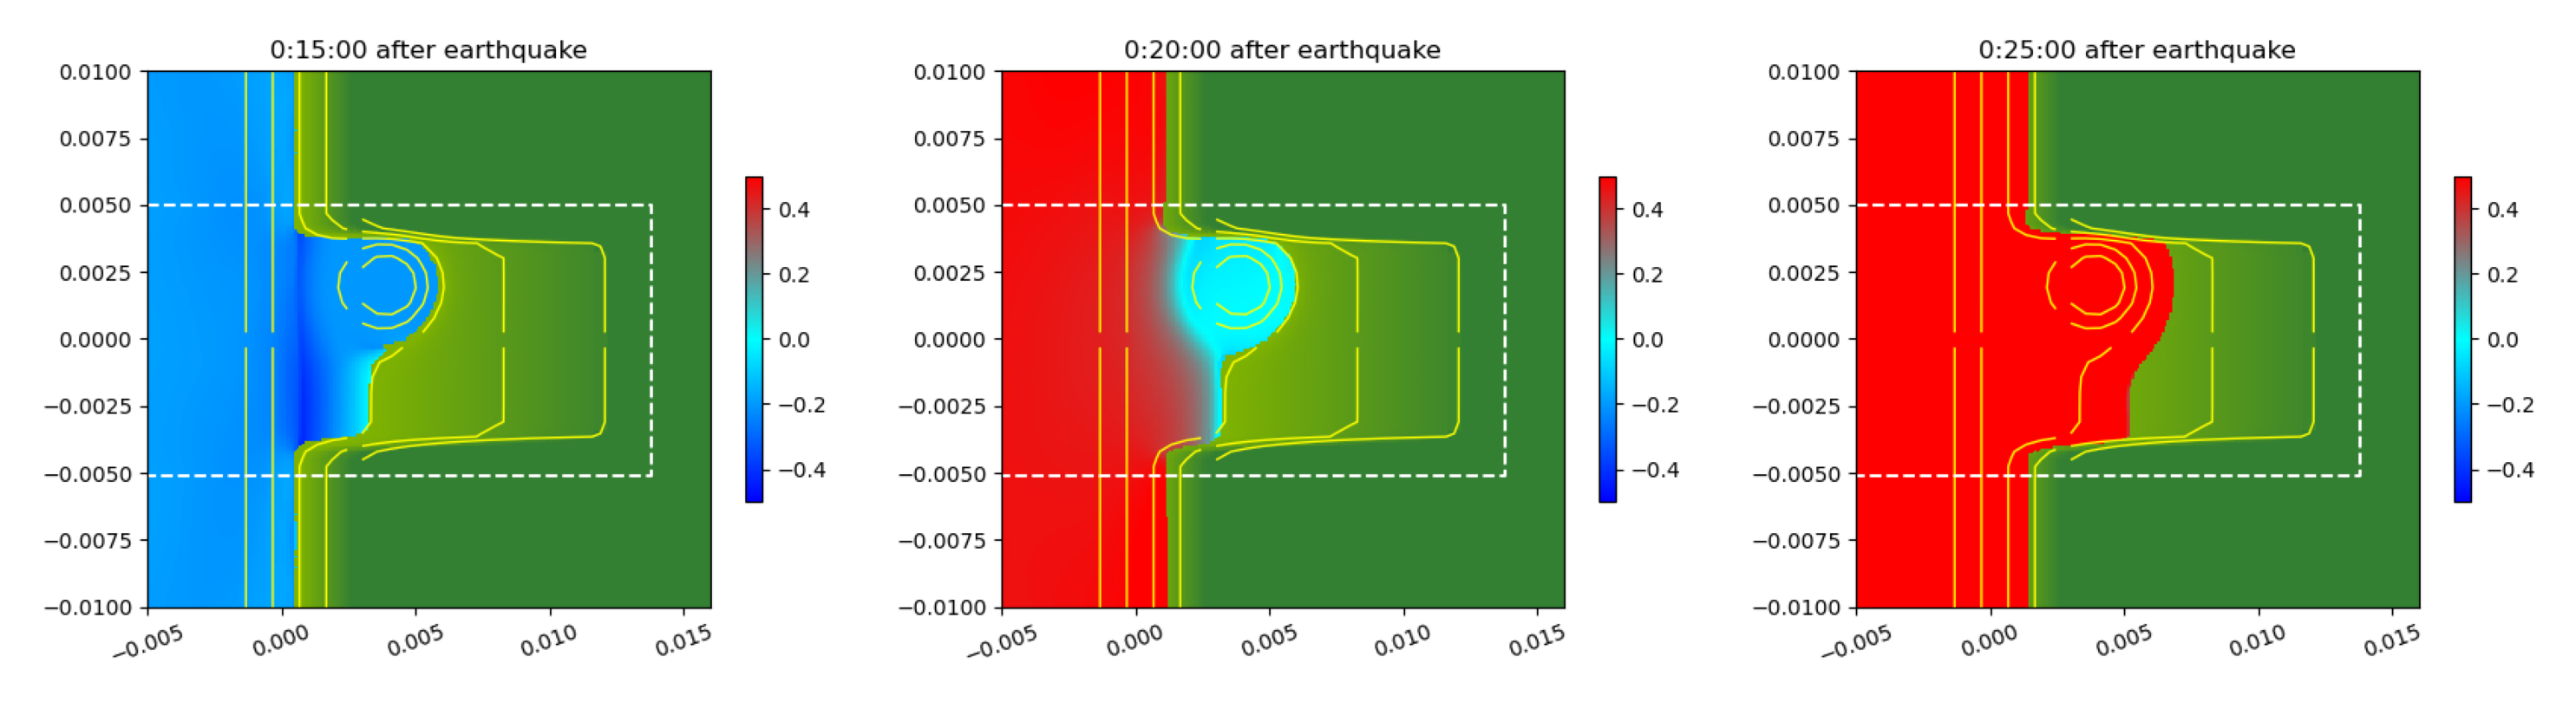

In [21]:
plotdir = '_plots_1'
plot_3frames(plotdir, figno=11, framenos=[3,4,5])

In these plots we see that the depression and other onshore areas were already filled with water before the positive tsunami wave arrive, and that it then sweeps over the "lake" much more quickly.

## Transect plots

It is easier to visualize the flow in each case by plotting the solution along transects through the depression.  See the notebook [gridtools.ipynb](gridtools.ipynb) for more discussion of the `gridtools` module used here:

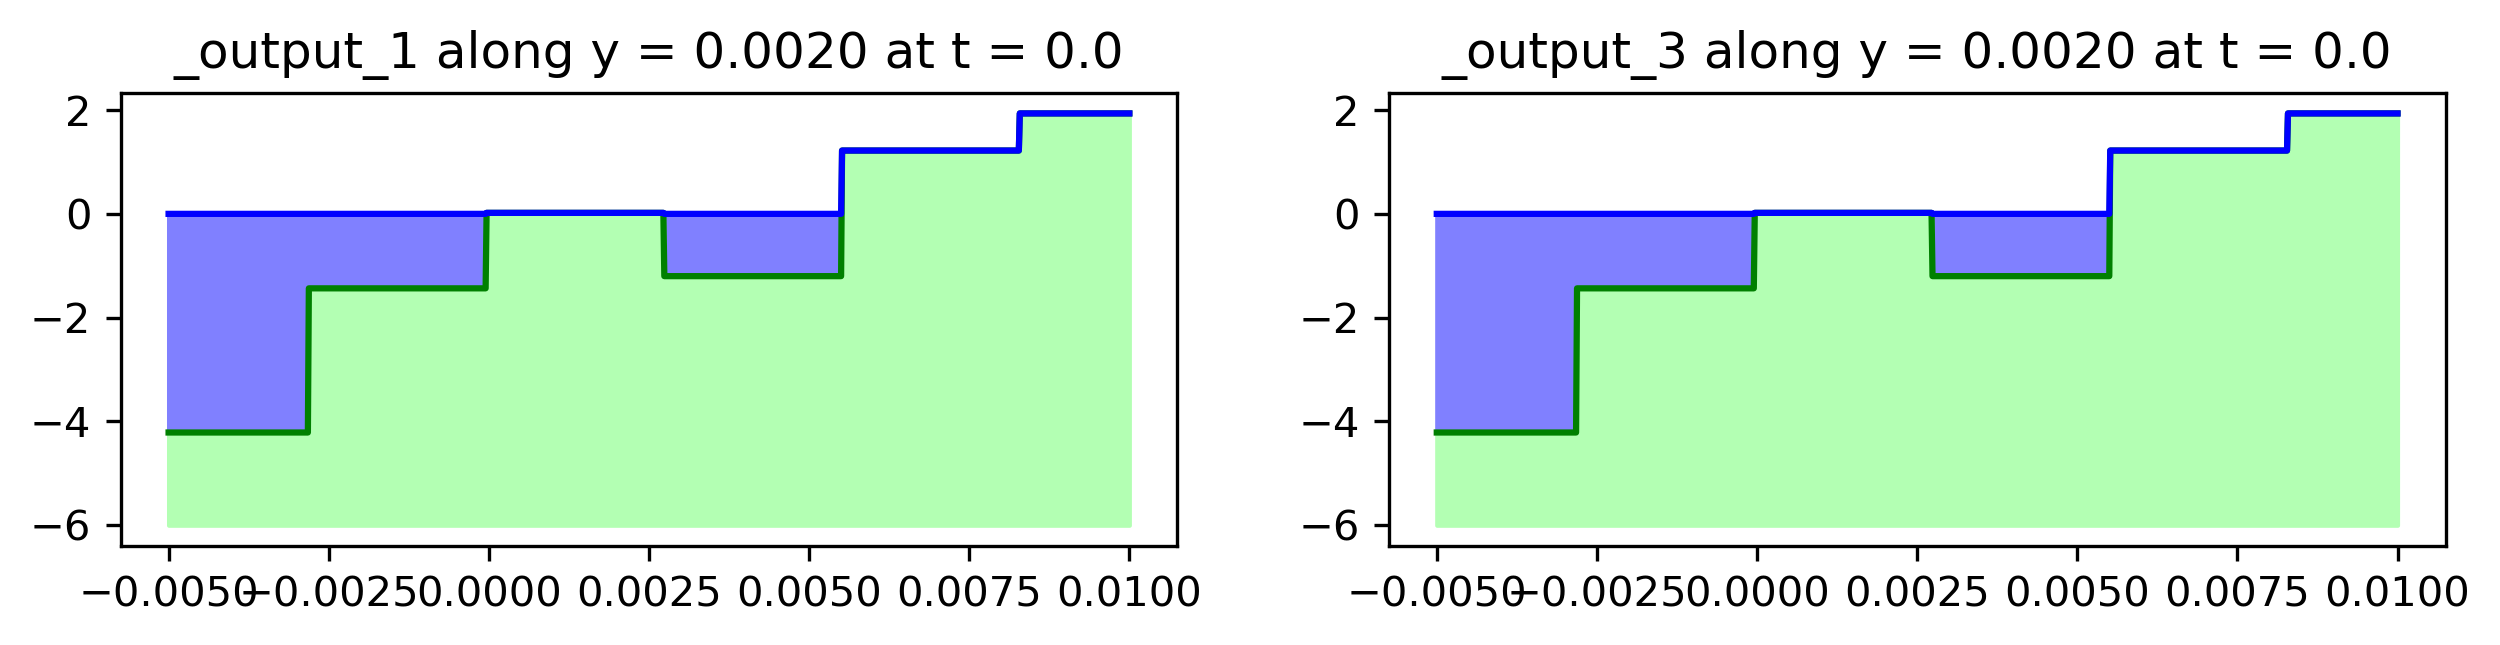

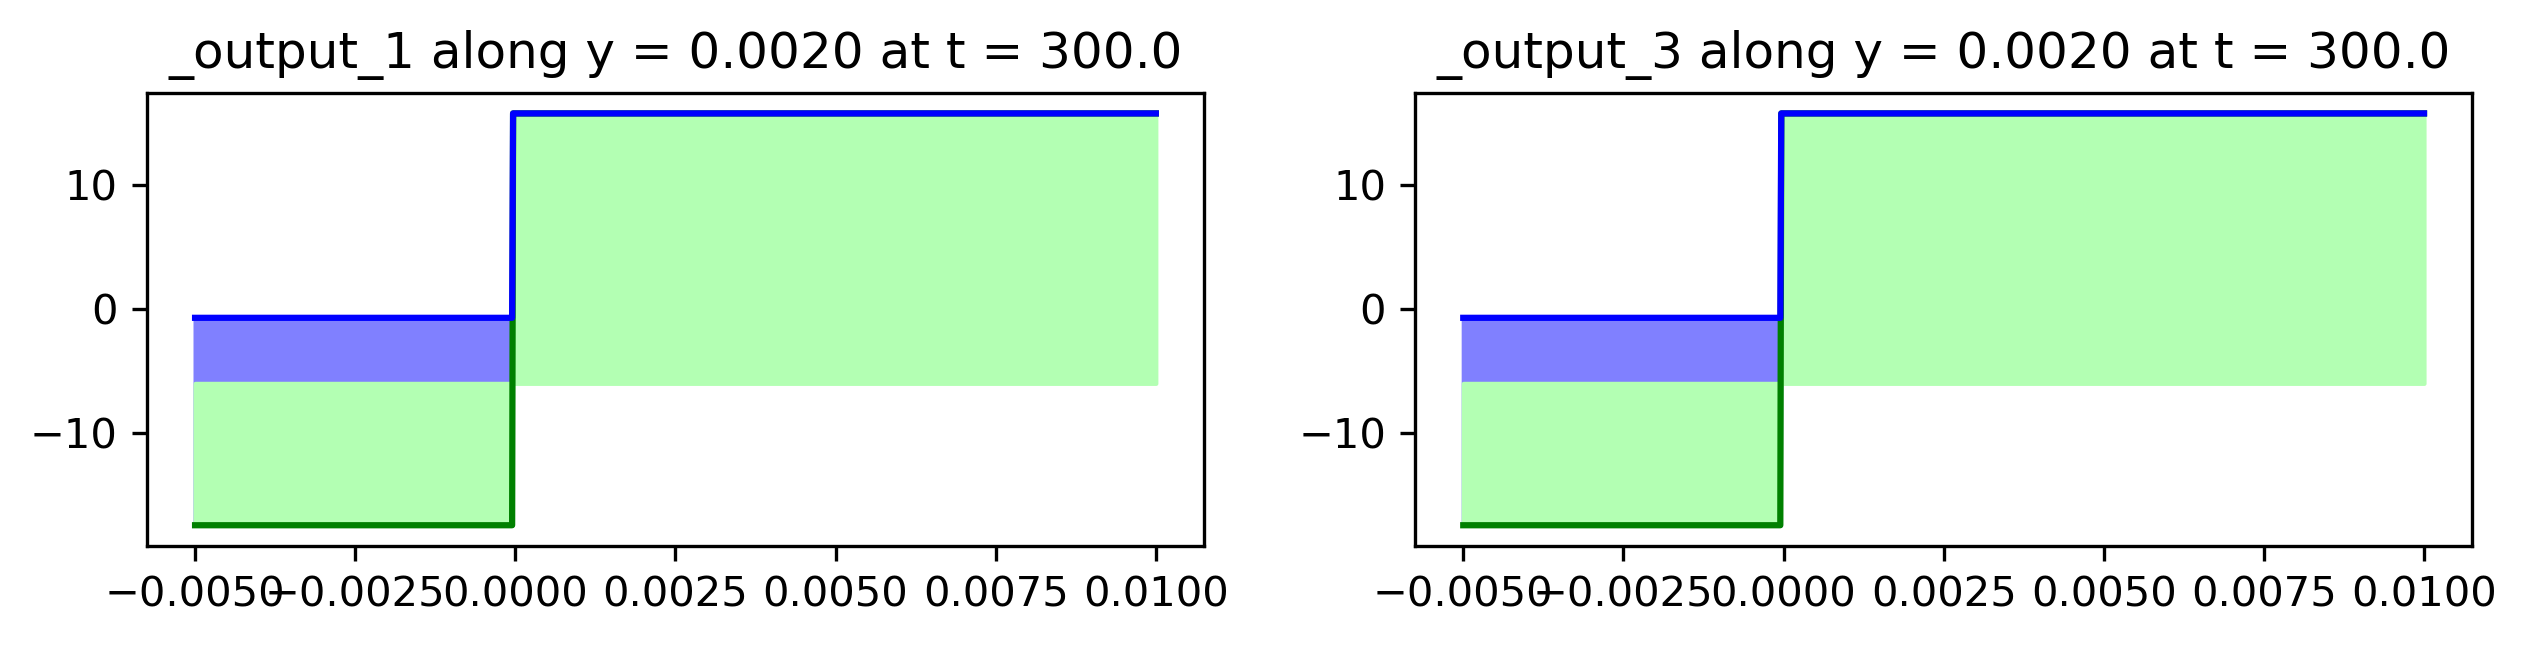

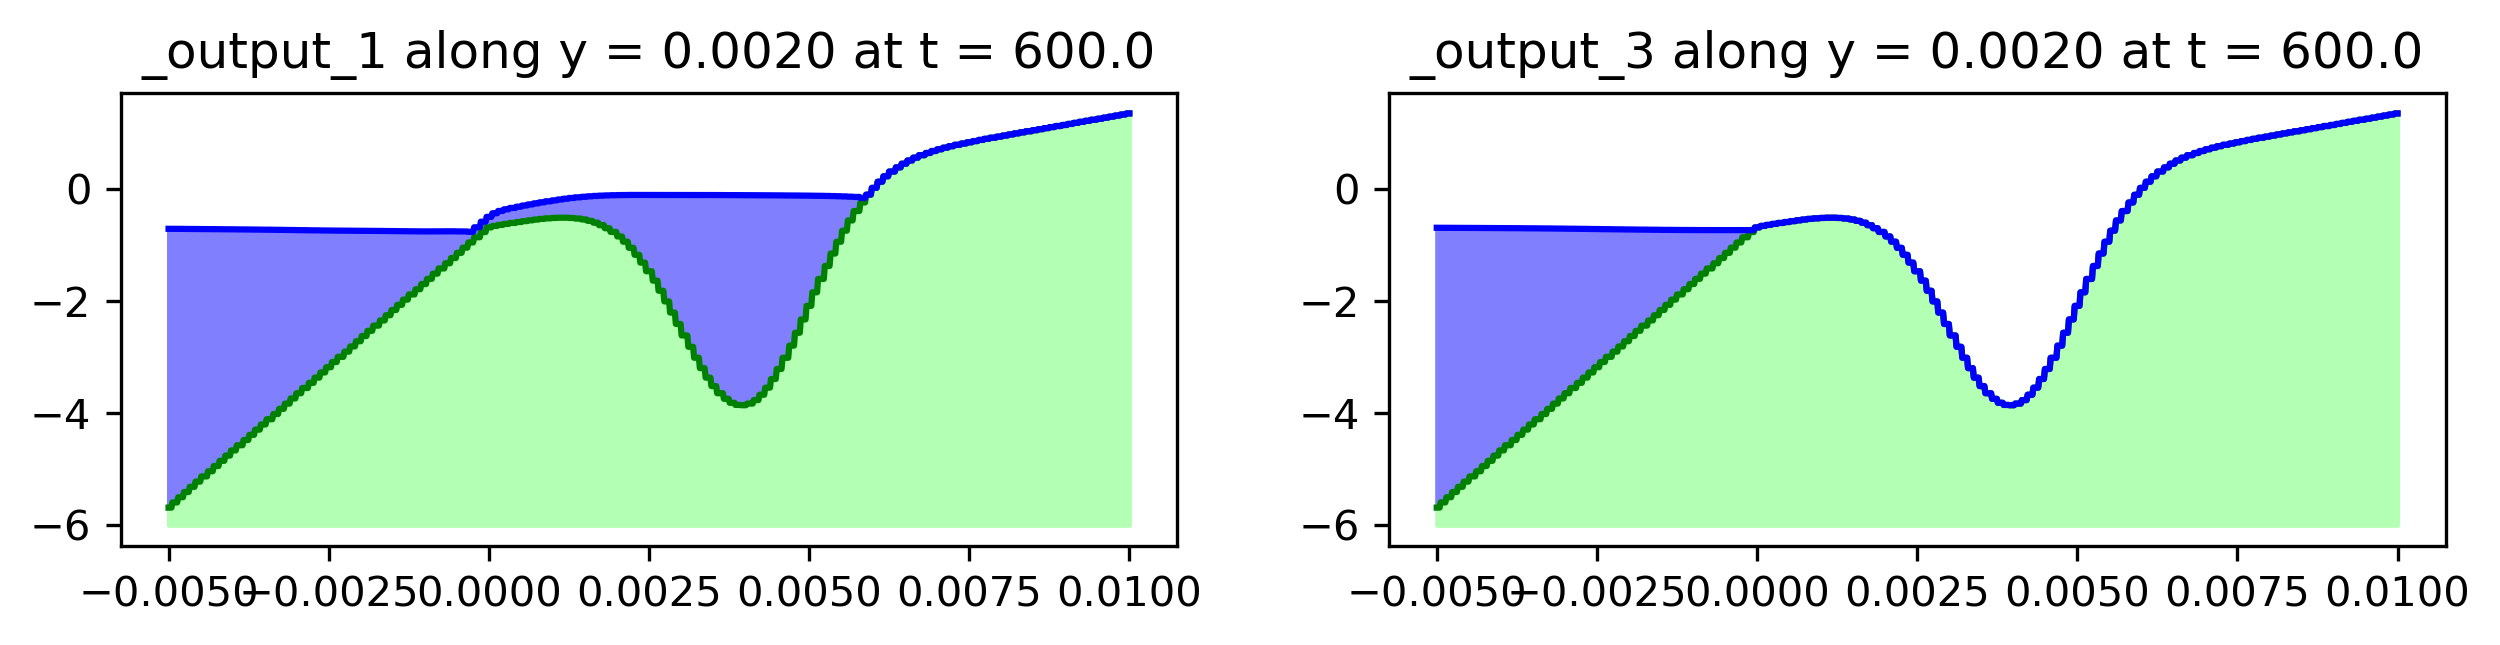

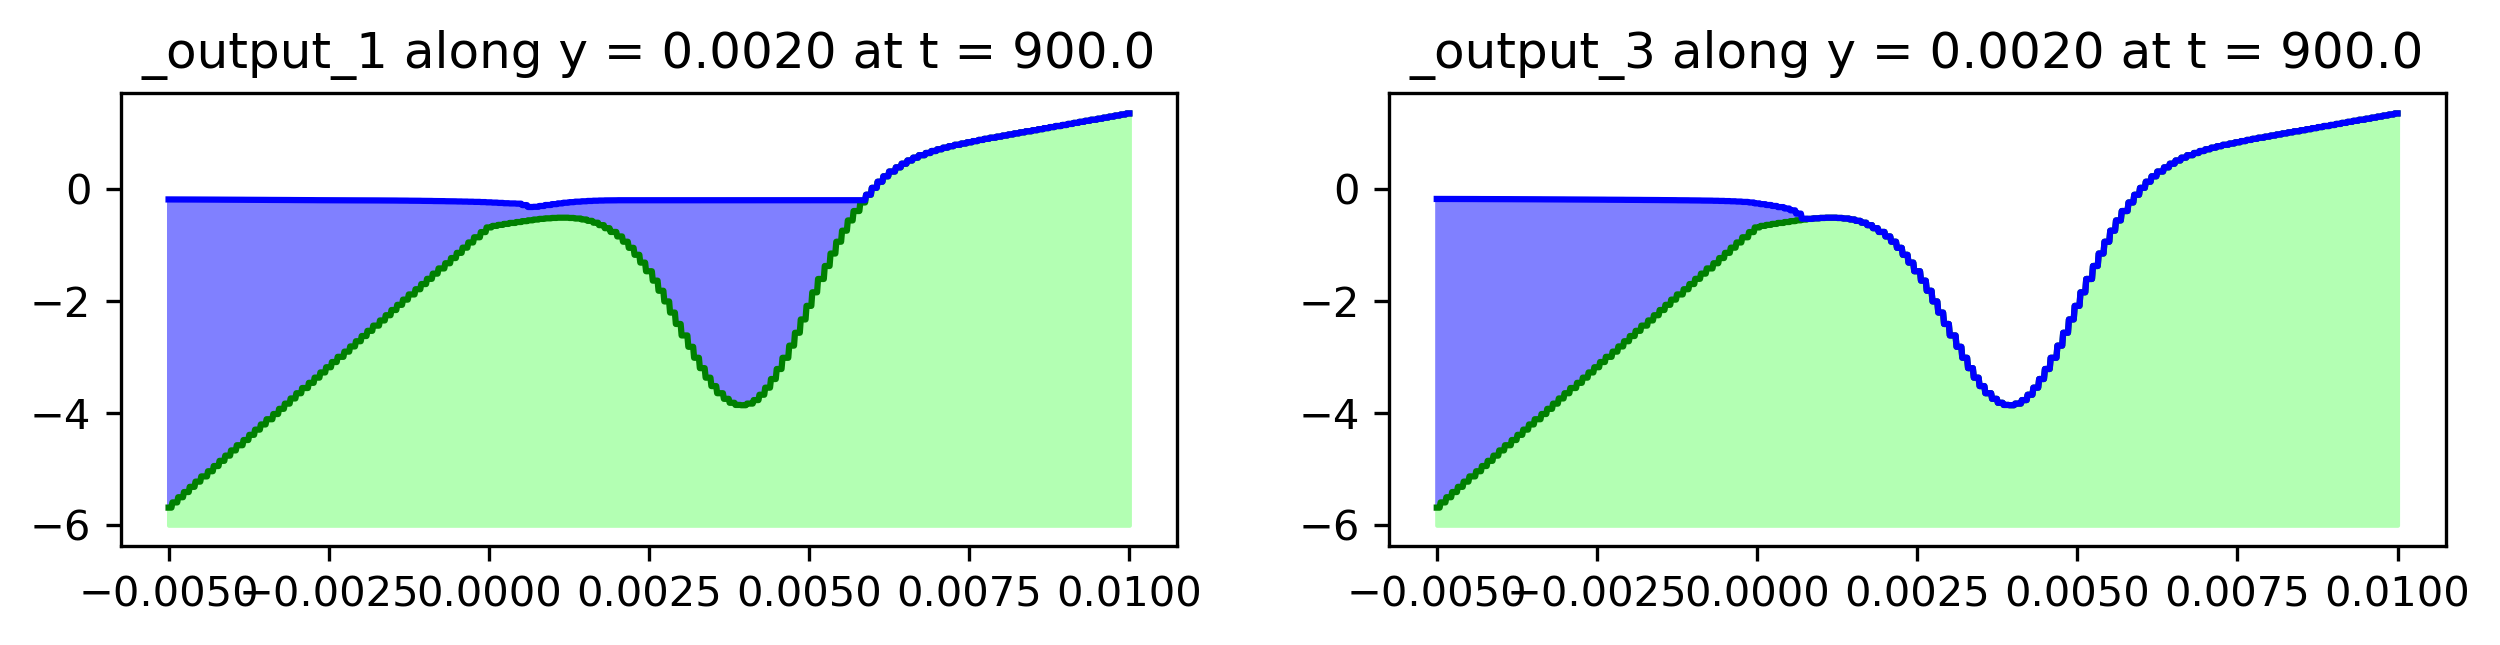

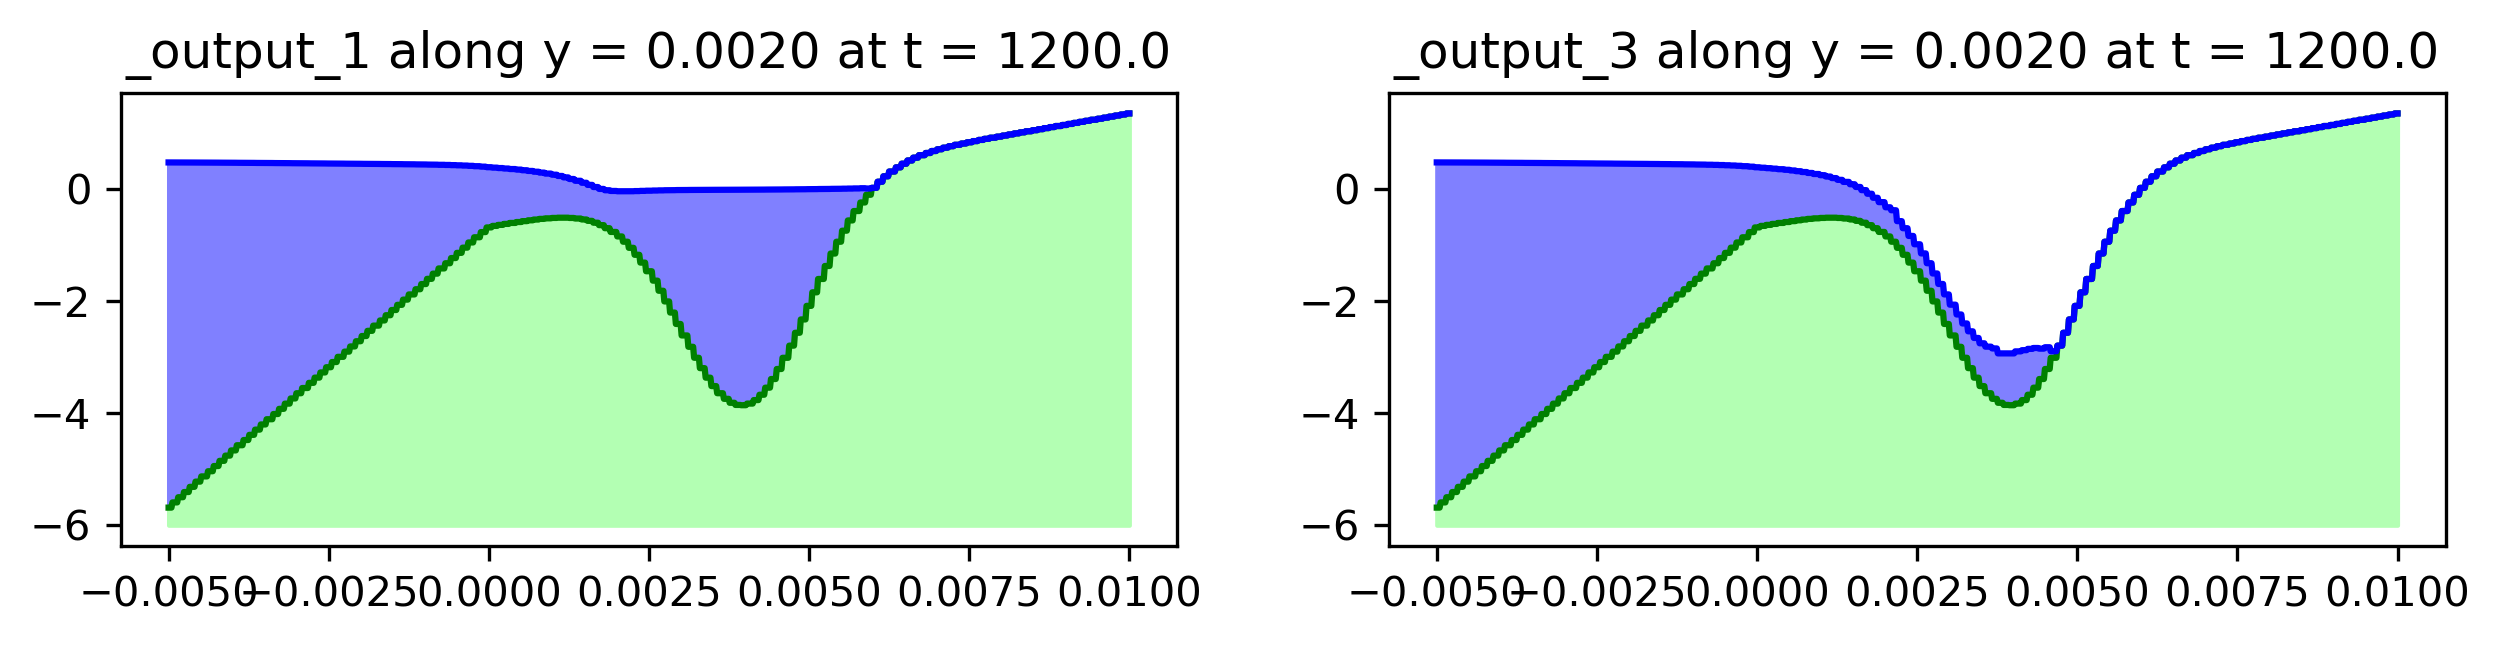

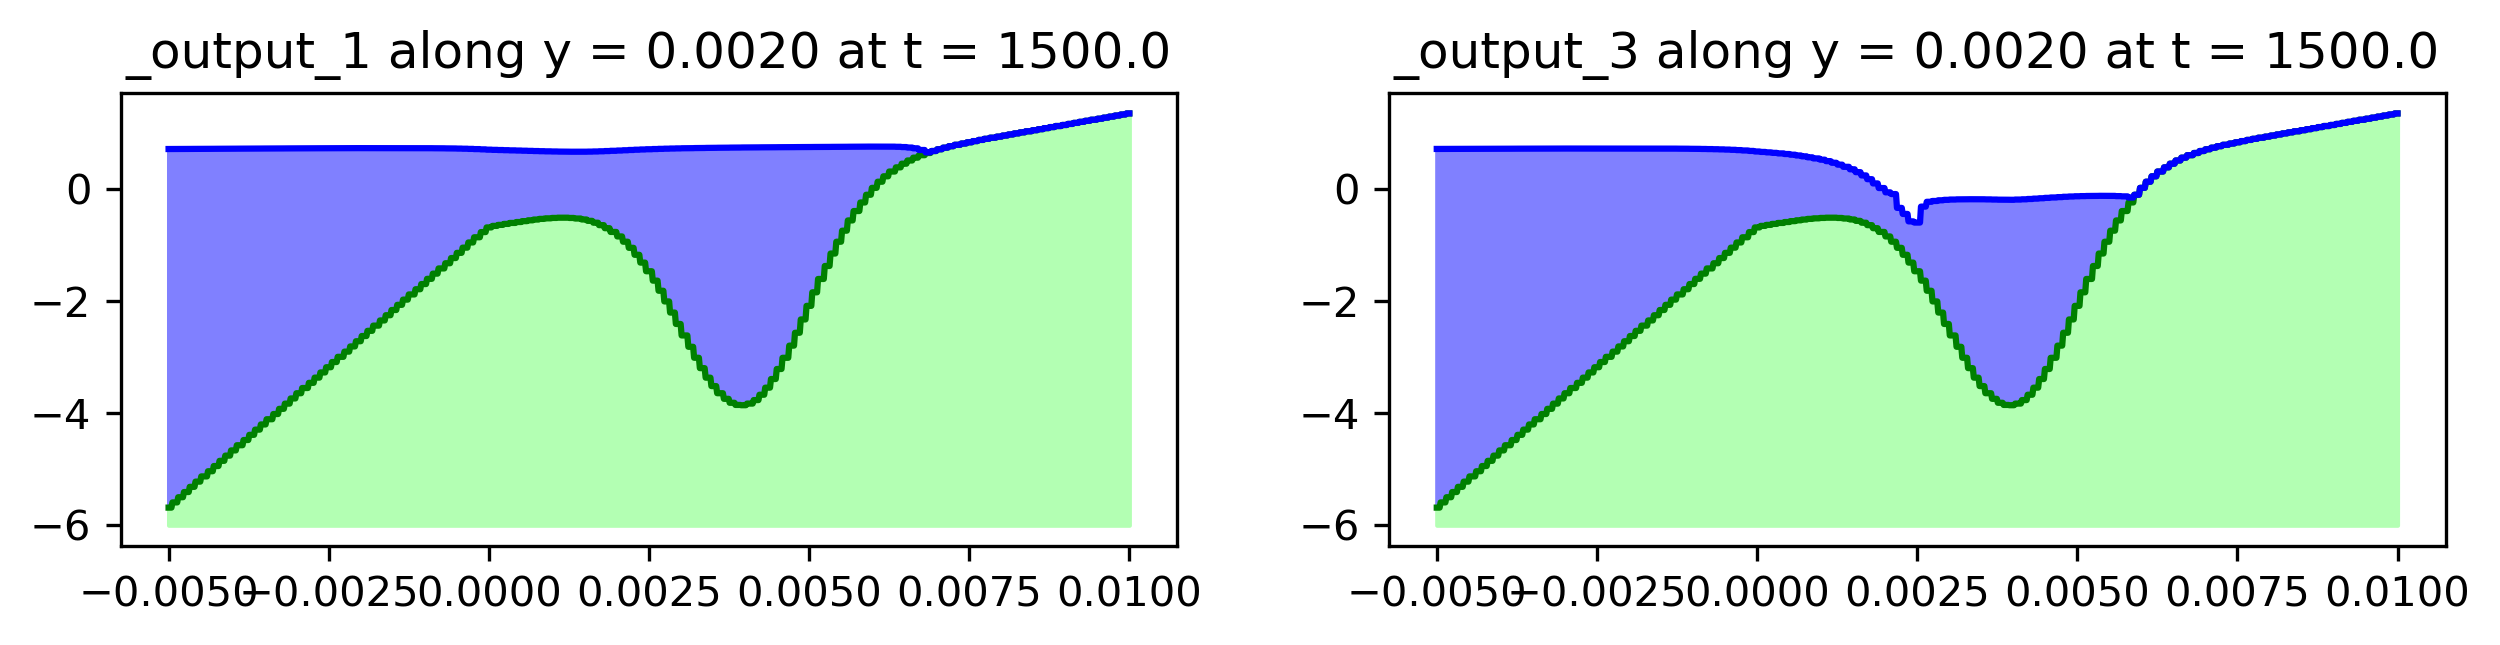

In [22]:
eta = lambda q: q[3,:,:]
B = lambda q: q[3,:,:]-q[0,:,:]
out_var = lambda q: array((B(q),eta(q)))

xout = linspace(-0.005, 0.01, 1001)
ylat = 0.002
yout = ylat * ones(xout.shape)

for frameno in range(6):
    figure(figsize=(10,2))
    subplot(121)
    framesoln = solution.Solution(frameno, path='_output_1', file_format='binary')
    qout = gridtools.grid_output_2d(framesoln, out_var, xout, yout, 
                                     levels='all',return_ma=True)
    B_out = qout[0,:]
    eta_out = qout[1,:]
    
    fill_between(xout, eta_out, B_out, color=[.5,.5,1])
    fill_between(xout, B_out, -6, color=[.7,1,.7])
    plot(xout, B_out, 'g')
    plot(xout, eta_out, 'b')
    title('_output_1 along y = %.4f at t = %.1f' % (ylat, framesoln.t))
    
    subplot(122)
    framesoln = solution.Solution(frameno, path='_output_3', file_format='binary')
    qout = gridtools.grid_output_2d(framesoln, out_var, xout, yout, 
                                     levels='all',return_ma=True)
    B_out = qout[0,:]
    eta_out = qout[1,:]
    
    fill_between(xout, eta_out, B_out, color=[.5,.5,1])
    fill_between(xout, B_out, -6, color=[.7,1,.7])
    plot(xout, B_out, 'g')
    plot(xout, eta_out, 'b')
    title('_output_3 along y = %.4f at t = %.1f' % (ylat, framesoln.t))

In the plots above, the left column shows the results from the first test, where the depression was initially a lake, even on the finest grid resolution, while the right column shows the more correct results when the depression is initialized to dry (once the finest grid level is introduced in this region).